<a href="https://colab.research.google.com/github/BillWorstell/InstallingToolsFromColab/blob/main/Installing_PYRO_NN_On_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install tensorflow==2.3.0

In [7]:
pip install tensorflow 

In [8]:
import tensorflow
print(tensorflow.__version__)

2.3.0


In [9]:
pip install pyronn

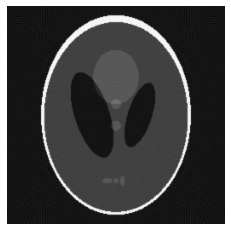

In [10]:
# Copyright [2019] [Christopher Syben, Markus Michen]
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# TODO: better imports
from pyronn.ct_reconstruction.layers.projection_2d import fan_projection2d
from pyronn.ct_reconstruction.layers.backprojection_2d import fan_backprojection2d
from pyronn.ct_reconstruction.geometry.geometry_fan_2d import GeometryFan2D
from pyronn.ct_reconstruction.helpers.phantoms import shepp_logan
from pyronn.ct_reconstruction.helpers.trajectories import circular_trajectory
from pyronn.ct_reconstruction.helpers.filters import filters
from pyronn.ct_reconstruction.helpers.filters import weights

def example_fan_2d():
    # ------------------ Declare Parameters ------------------

    # Volume Parameters:
    volume_size = 256
    volume_shape = [volume_size, volume_size]
    volume_spacing = [1,1]

    # Detector Parameters:
    detector_shape = 800
    detector_spacing = 1

    # Trajectory Parameters:
    number_of_projections = 360
    angular_range = 2*np.pi

    source_detector_distance = 1200
    source_isocenter_distance = 750

    # create Geometry class
    geometry = GeometryFan2D(volume_shape, volume_spacing, detector_shape, detector_spacing, number_of_projections, angular_range, source_detector_distance, source_isocenter_distance)
    geometry.set_trajectory(circular_trajectory.circular_trajectory_2d(geometry))

    # Get Phantom
    phantom = shepp_logan.shepp_logan_enhanced(volume_shape)
    # Add required batch dimension
    phantom = np.expand_dims(phantom,axis=0)
    # ------------------ Call Layers ------------------

    sinogram = fan_projection2d(phantom, geometry)

    #TODO: Add Cosine weighting
    #TODO: Add redundancy weighting for 360 degree

    reco_filter = filters.ramp_2D(geometry)
    sino_freq = tf.signal.fft(tf.cast(sinogram,dtype=tf.complex64))
    sino_filtered_freq = tf.multiply(sino_freq,tf.cast(reco_filter,dtype=tf.complex64))
    sinogram_filtered = tf.math.real(tf.signal.ifft(sino_filtered_freq))

    reco = fan_backprojection2d(sinogram_filtered, geometry)

    plt.figure()
    plt.imshow(np.squeeze(reco), cmap=plt.get_cmap('gist_gray'))
    plt.axis('off')
    plt.savefig('2d_fan_reco.png', dpi=150, transparent=False, bbox_inches='tight')


if __name__ == '__main__':
    example_fan_2d()